In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot

from IPython.display import Image

TRAIN = True

np.random.seed(1)
tf.random.set_seed(1)

sns.set_theme(palette='tab10')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    
    try:
        
        for gpu in gpus:
            
            tf.config.experimental.set_memory_growth(gpu, True)
    
    except RuntimeError as e:
        
        sys.stderr.write(str(e))

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

In [4]:
# pad images to get 32 x 32 inputs (convenience)
X_train = tf.pad(X_train, ((0, 0), (2, 2), (2, 2)))
X_test = tf.pad(X_test, ((0, 0), (2, 2), (2, 2)))

In [5]:
y_train = tf.one_hot(y_train, depth=y_train.max()+1)

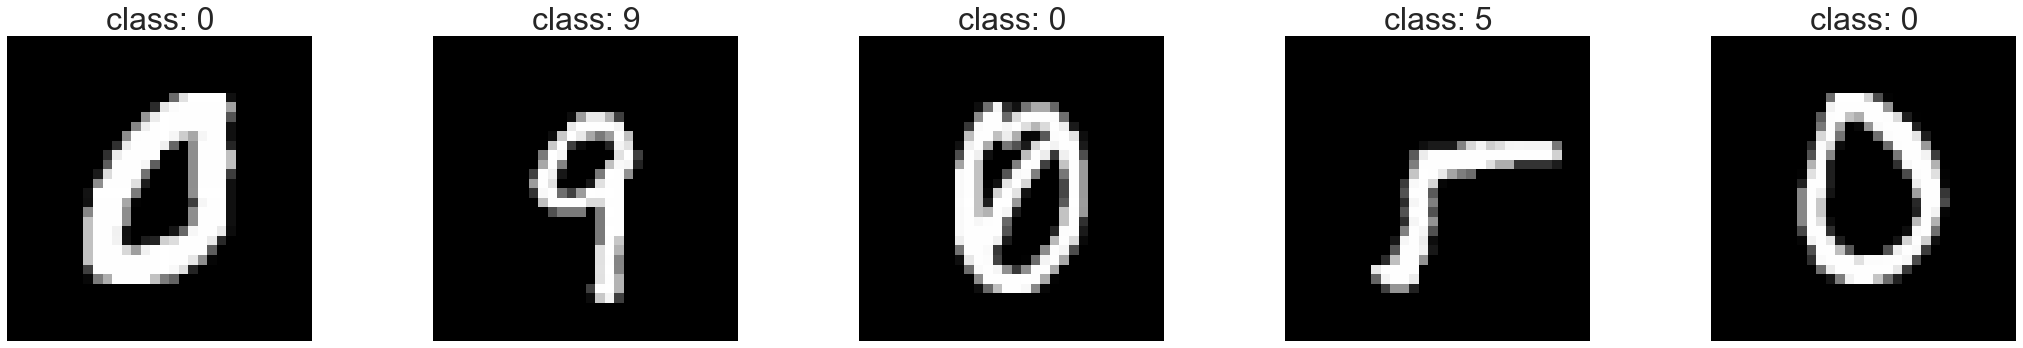

In [6]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_train.shape[0], size=5)

for n, i in enumerate(idx):
    
    sns.heatmap(data=X_train[i], cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
               )
    
    ax[n].set_title(f'class: {np.argmax(y_train[i]):d}', fontsize=32)
    
plt.tight_layout()

In [7]:
K.clear_session()

cnn = Sequential([Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(None, None, 1), name='cnn_input'),
                  MaxPool2D(pool_size=(3, 3), name='cnn_pool_1'),
                  Conv2D(filters=8, kernel_size=(2, 2), activation='relu', name='cnn_hidden_1'),
                  MaxPool2D(pool_size=(2, 2), name='cnn_pool_2'),
                  Conv2D(filters=8, kernel_size=(2, 2), activation='relu', name='cnn_hidden_2'),
                  MaxPool2D(pool_size=(2, 2), name='cnn_pool_3'),
                  Conv2D(filters=10, kernel_size=(1, 1), activation='softmax', name='cnn_output')
                 ],
                 name='fully_convolutional_nn'
                )

cnn.summary()

Model: "fully_convolutional_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (Conv2D)           (None, None, None, 16)    160       
_________________________________________________________________
cnn_pool_1 (MaxPooling2D)    (None, None, None, 16)    0         
_________________________________________________________________
cnn_hidden_1 (Conv2D)        (None, None, None, 8)     520       
_________________________________________________________________
cnn_pool_2 (MaxPooling2D)    (None, None, None, 8)     0         
_________________________________________________________________
cnn_hidden_2 (Conv2D)        (None, None, None, 8)     264       
_________________________________________________________________
cnn_pool_3 (MaxPooling2D)    (None, None, None, 8)     0         
_________________________________________________________________
cnn_output (Conv2D)          (None, None, No

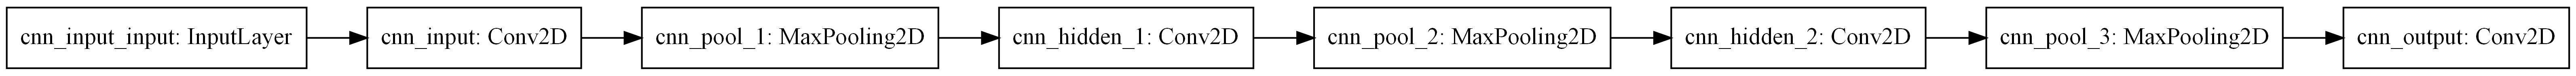

In [8]:
cnn_dot = model_to_dot(cnn, dpi=300, rankdir='LR')
Image(cnn_dot.create_png(), width=1024)

In [9]:
cnn.compile(optimizer=Adam(learning_rate=1.0e-3), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

if TRAIN:
    
    history = cnn.fit(x=X_train[:50000, :, :, None], y=y_train[:50000, None, None, :],
                      batch_size=32, epochs=10,
                      validation_data=(X_train[50000:, :, :, None], y_train[50000:, None, None, :]),
                      callbacks=[ModelCheckpoint('./fully_convolutional_nn.h5', save_best_only=True)]
                     )

cnn.load_weights('./fully_convolutional_nn.h5')

Epoch 1/10
1563/1563 [==============================] - 9s 4ms/step - loss: 0.9944 - categorical_accuracy: 0.6738 - val_loss: 0.5100 - val_categorical_accuracy: 0.8522
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4733 - categorical_accuracy: 0.8594 - val_loss: 0.3798 - val_categorical_accuracy: 0.8922
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3807 - categorical_accuracy: 0.8887 - val_loss: 0.3176 - val_categorical_accuracy: 0.9103
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3273 - categorical_accuracy: 0.9038 - val_loss: 0.2853 - val_categorical_accuracy: 0.9200
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2936 - categorical_accuracy: 0.9139 - val_loss: 0.2646 - val_categorical_accuracy: 0.9259
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2708 - categorical_accuracy: 0.9202 - val_loss: 0.2461 - val_categorical_accuracy:

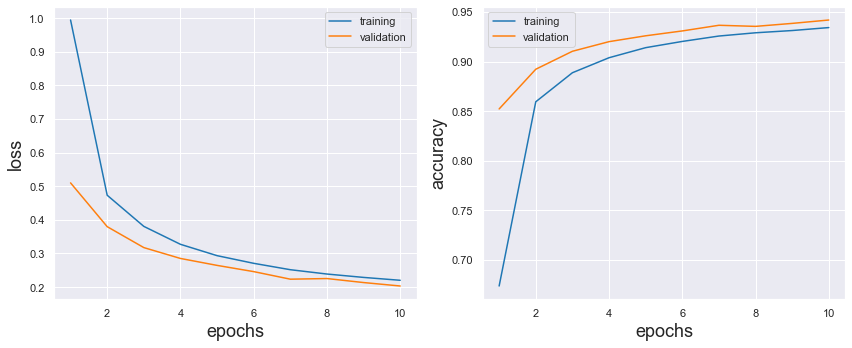

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=range(1, 10+1), y=history.history['loss'],
             ls='-', color='tab:blue', label='training', ax=ax[0]
            )
sns.lineplot(x=range(1, 10+1), y=history.history['val_loss'],
             ls='-', color='tab:orange', label='validation', ax=ax[0]
            )
ax[0].set_xlabel('epochs', fontsize=18)
ax[0].set_ylabel('loss', fontsize=18)

sns.lineplot(x=range(1, 10+1), y=history.history['categorical_accuracy'],
             ls='-', color='tab:blue', label='training', ax=ax[1]
            )
sns.lineplot(x=range(1, 10+1), y=history.history['val_categorical_accuracy'],
             ls='-', color='tab:orange', label='validation', ax=ax[1]
            )
ax[1].set_xlabel('epochs', fontsize=18)
ax[1].set_ylabel('accuracy', fontsize=18)

plt.tight_layout()

In [11]:
y_pred = cnn.predict(X_test[:, :, :, None]).squeeze().argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred == y_test).mean():.2%}')

Prediction accuracy: 94.42%


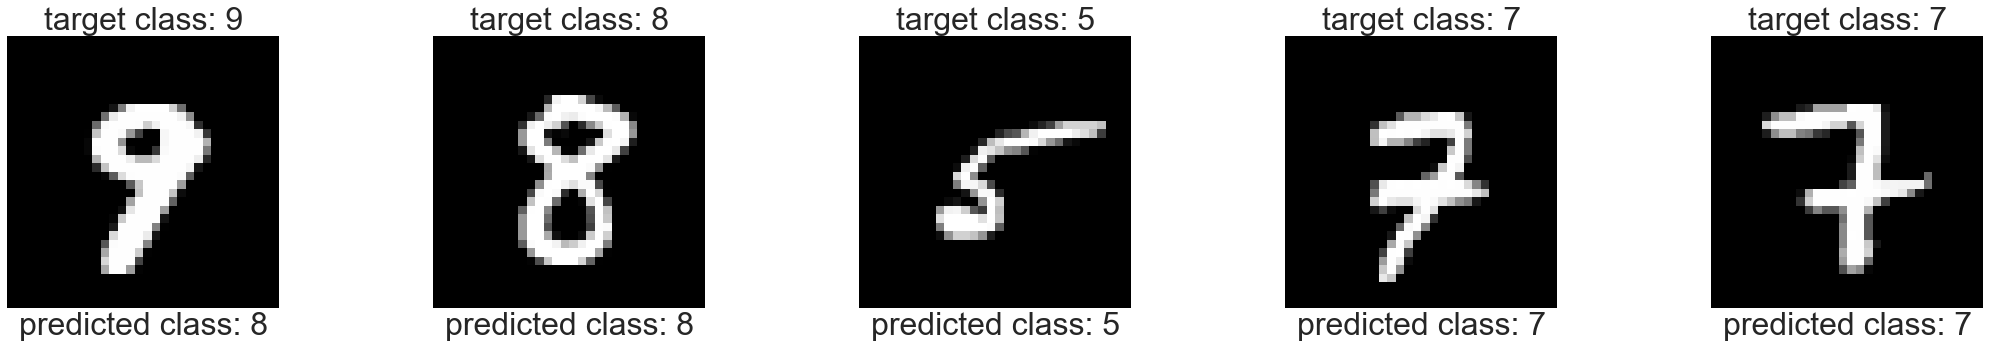

In [12]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=5)

for n, i in enumerate(idx):
    
    sns.heatmap(data=X_test[i], cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
               )
    
    ax[n].set_title(f'target class: {y_test[i]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {y_pred[i]:d}', fontsize=32)
    
plt.tight_layout()

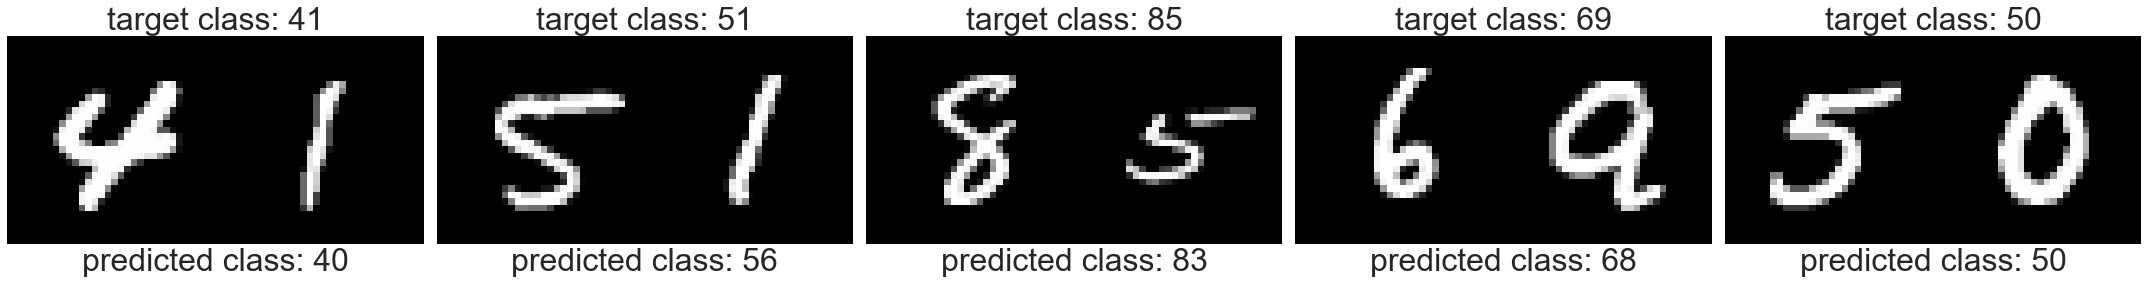

In [13]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=10)
for n in range(5):
    
    conc = np.concatenate([X_test[idx[n]], X_test[idx[9-n]]], axis=1)
    
    sns.heatmap(data=conc, cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
               )
    
    pred = cnn.predict(conc[None, :, :, None]).squeeze().argmax(axis=1)
    ax[n].set_title(f'target class: {y_test[idx[n]]:d}{y_test[idx[9-n]]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}', fontsize=32)
    
plt.tight_layout()

In [14]:
X_train_noise = X_train + 1.75 * np.random.uniform(size=X_train.shape)
X_test_noise = X_test + 1.75 * np.random.uniform(size=X_test.shape)
y_pred_noise = cnn.predict(X_test_noise[:, :, :, None]).squeeze().argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred_noise == y_test).mean():.2%}')

Prediction accuracy: 10.26%


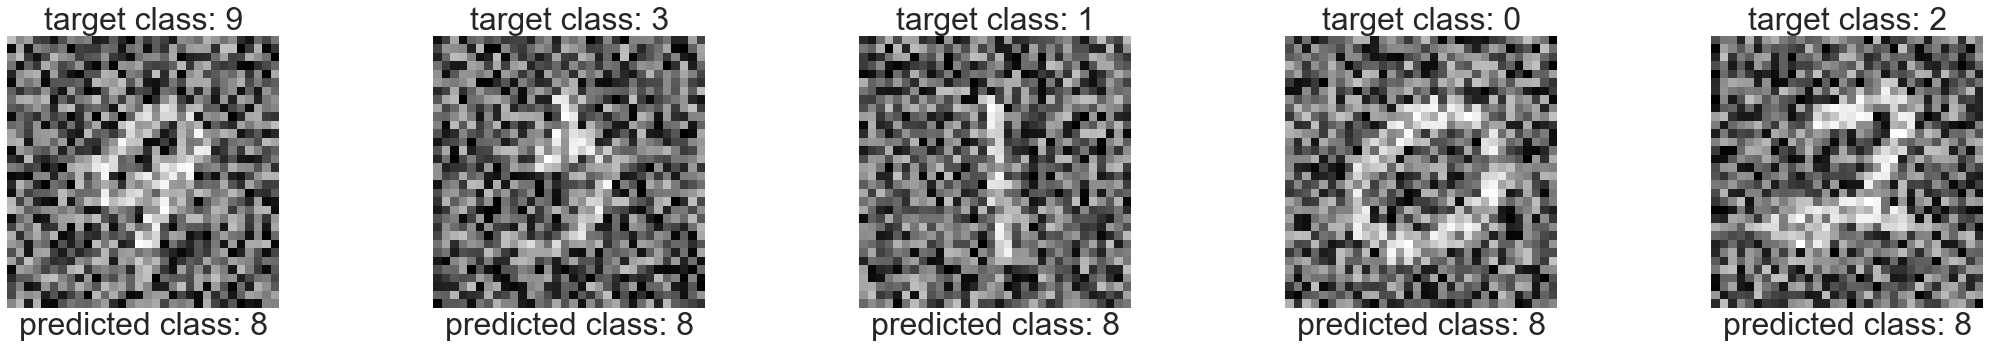

In [15]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test_noise.shape[0], size=5)

for n, i in enumerate(idx):
    
    sns.heatmap(data=X_test_noise[i], cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
               )
    
    ax[n].set_title(f'target class: {y_test[i]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {y_pred_noise[i]:d}', fontsize=32)
    
plt.tight_layout()

In [16]:
K.clear_session()

ae = Sequential([Conv2D(filters=128, kernel_size=(3, 3), activation='tanh', input_shape=(None, None, 1), name='ae_input'),
                 MaxPool2D(pool_size=(3, 3), name='ae_pool_1'),
                 Conv2D(filters=64, kernel_size=(2, 2), activation='tanh', name='ae_down_1'),
                 MaxPool2D(pool_size=(2, 2), name='ae_pool_2'),
                 Conv2D(filters=64, kernel_size=(2, 2), activation='tanh', name='ae_down_2'),
                 UpSampling2D(size=(3, 3), name='ae_upsample_1'),
                 Conv2DTranspose(filters=64, kernel_size=(2, 2), activation='relu', name='ae_up_1'),
                 UpSampling2D(size=(3, 3), name='ae_upsample_2'),
                 Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', name='ae_up_2'),
                 Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', name='ae_output'),
                ],
                name='autoencoder'
               )

ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (Conv2D)            (None, None, None, 128)   1280      
_________________________________________________________________
ae_pool_1 (MaxPooling2D)     (None, None, None, 128)   0         
_________________________________________________________________
ae_down_1 (Conv2D)           (None, None, None, 64)    32832     
_________________________________________________________________
ae_pool_2 (MaxPooling2D)     (None, None, None, 64)    0         
_________________________________________________________________
ae_down_2 (Conv2D)           (None, None, None, 64)    16448     
_________________________________________________________________
ae_upsample_1 (UpSampling2D) (None, None, None, 64)    0         
_________________________________________________________________
ae_up_1 (Conv2DTranspose)    (None, None, None, 64)    

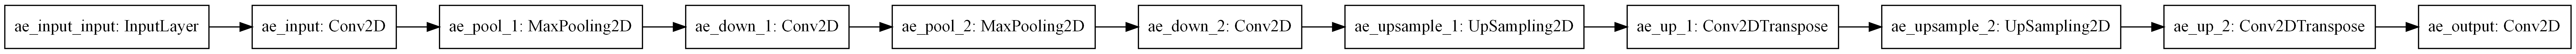

In [17]:
ae_dot = model_to_dot(ae, dpi=300, rankdir='LR')
Image(ae_dot.create_png(), width=1024)

In [18]:
ae.compile(optimizer=Adam(learning_rate=1.0e-3), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

if TRAIN:
    
    history = ae.fit(x=X_train_noise[:50000, :, :, None], y=X_train[:50000, :, :, None],
                     batch_size=32, epochs=10,
                     validation_data=(X_train_noise[50000:, :, :, None], X_train[50000:, :, :, None]),
                     callbacks=[ModelCheckpoint('./autoencoder.h5', save_best_only=True)]
                    )

ae.load_weights('./autoencoder.h5')

Epoch 1/10
1563/1563 [==============================] - 22s 13ms/step - loss: 0.1679 - binary_accuracy: 0.8423 - val_loss: 0.1440 - val_binary_accuracy: 0.8400
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1346 - binary_accuracy: 0.8455 - val_loss: 0.1291 - val_binary_accuracy: 0.8440
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1254 - binary_accuracy: 0.8470 - val_loss: 0.1228 - val_binary_accuracy: 0.8471
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1215 - binary_accuracy: 0.8477 - val_loss: 0.1214 - val_binary_accuracy: 0.8476
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1191 - binary_accuracy: 0.8482 - val_loss: 0.1196 - val_binary_accuracy: 0.8466
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1175 - binary_accuracy: 0.8484 - val_loss: 0.1174 - val_binary_accuracy: 0.8506
Epoch 7/10
1563/1563 [==================

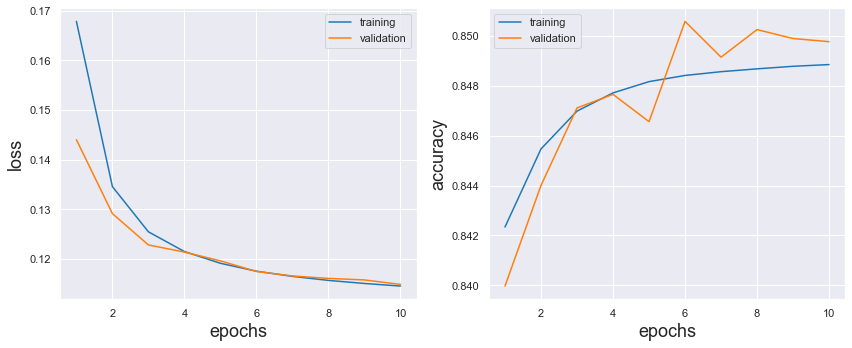

In [19]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=range(1, 10+1), y=history.history['loss'],
             ls='-', color='tab:blue', label='training', ax=ax[0]
            )
sns.lineplot(x=range(1, 10+1), y=history.history['val_loss'],
             ls='-', color='tab:orange', label='validation', ax=ax[0]
            )
ax[0].set_xlabel('epochs', fontsize=18)
ax[0].set_ylabel('loss', fontsize=18)

sns.lineplot(x=range(1, 10+1), y=history.history['binary_accuracy'],
             ls='-', color='tab:blue', label='training', ax=ax[1]
            )
sns.lineplot(x=range(1, 10+1), y=history.history['val_binary_accuracy'],
             ls='-', color='tab:orange', label='validation', ax=ax[1]
            )
ax[1].set_xlabel('epochs', fontsize=18)
ax[1].set_ylabel('accuracy', fontsize=18)

plt.tight_layout()

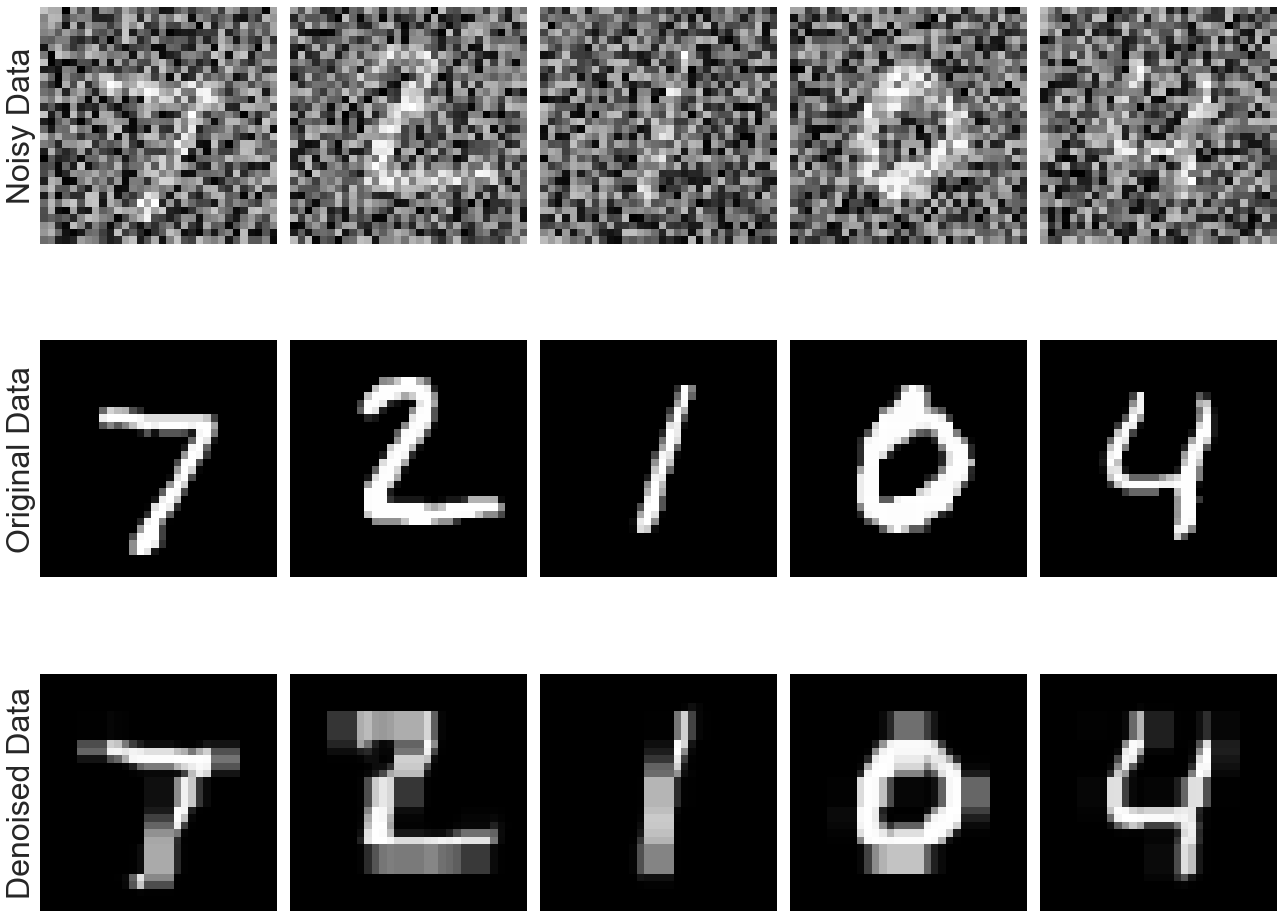

In [20]:
X_preds = ae.predict(X_test_noise[:, :, :, None]).squeeze()

_, ax = plt.subplots(3, 5, figsize=(18, 15), sharey=True, sharex=True)
idx = np.random.choice(X_preds.shape[0], size=5)

for n, i in enumerate(idx):
    
    sns.heatmap(data=X_test_noise[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
               )
    
    sns.heatmap(data=X_test[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
               )
    
    sns.heatmap(data=X_preds[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[2, n]
               )

ax[0, 0].set_ylabel('Noisy Data', fontsize=32)
ax[1, 0].set_ylabel('Original Data', fontsize=32)
ax[2, 0].set_ylabel('Denoised Data', fontsize=32)

plt.tight_layout()

In [21]:
K.clear_session()

cv = Model(inputs=ae.input, outputs=cnn(ae.output), trainable=False, name='CV')

cv.summary()

Model: "CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input_input (InputLayer)  [(None, None, None, 1)]   0         
_________________________________________________________________
ae_input (Conv2D)            (None, None, None, 128)   1280      
_________________________________________________________________
ae_pool_1 (MaxPooling2D)     (None, None, None, 128)   0         
_________________________________________________________________
ae_down_1 (Conv2D)           (None, None, None, 64)    32832     
_________________________________________________________________
ae_pool_2 (MaxPooling2D)     (None, None, None, 64)    0         
_________________________________________________________________
ae_down_2 (Conv2D)           (None, None, None, 64)    16448     
_________________________________________________________________
ae_upsample_1 (UpSampling2D) (None, None, None, 64)    0        

In [22]:
y_pred = cv.predict(X_test_noise[:, :, :, None]).squeeze().argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred == y_test).mean():.2%}')

Prediction accuracy: 80.11%


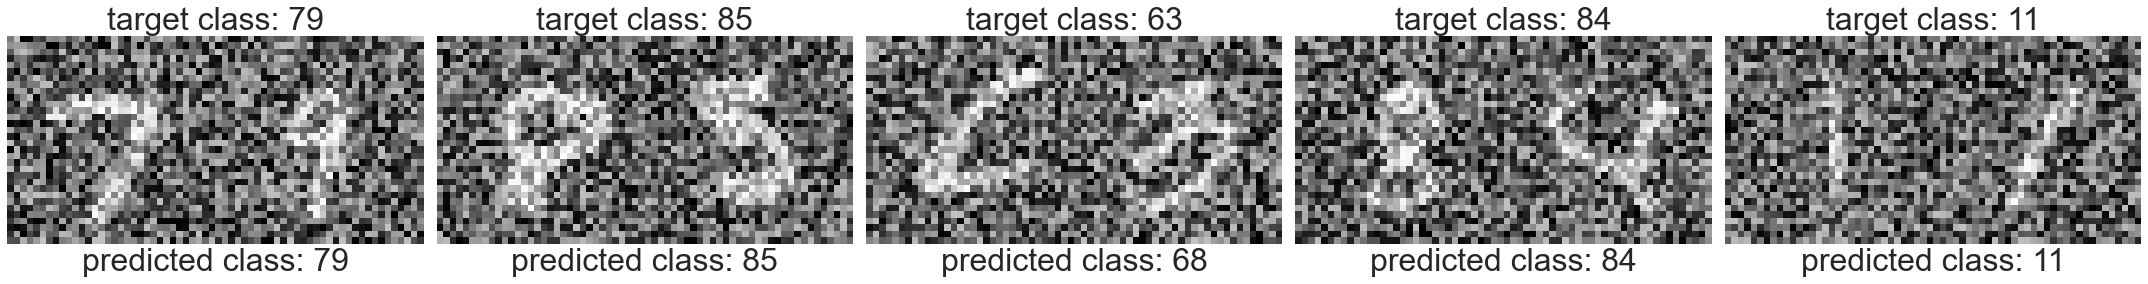

In [23]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=10)
for n in range(5):
    
    conc = np.concatenate([X_test_noise[idx[n]], X_test_noise[idx[9-n]]], axis=1)
    
    sns.heatmap(data=conc, cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
               )
    
    pred = cv.predict(conc[None, :, :, None]).squeeze().argmax(axis=1)
    ax[n].set_title(f'target class: {y_test[idx[n]]:d}{y_test[idx[9-n]]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}', fontsize=32)
    
plt.tight_layout()